In [95]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import numpy       as     np
import pandas      as     pd
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

from root_numpy import root2array,tree2array

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

In [121]:
data = root2array('flatNtuple_4topCI.root')
df = pd.DataFrame(data)
cols = df.columns.tolist()
cols = cols[1:-1] + [cols[0]]
df = df[cols]
df.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_pt4,jet_pt5,jet_pt6,jet_pt7,jet_pt8,jet_pt9,...,jet_phi0,jet_phi1,jet_phi2,jet_phi3,jet_phi4,jet_phi5,jet_phi6,jet_phi7,jet_phi8,m4top
0,433.247781,280.048812,191.256359,147.976812,125.145547,80.820656,59.403988,47.564422,39.361059,32.252859,...,-1.163880,2.762521,0.838950,2.303514,2.709872,0.954531,0.074848,0.702244,-1.307350,2067.372907
1,456.578062,343.047188,192.628344,132.609656,108.278969,68.977828,46.940559,44.167125,31.922500,31.568959,...,1.644464,-1.491458,-1.100206,2.640058,-2.268524,1.385526,-1.422107,0.137865,-0.662319,1589.237054
2,462.918625,289.672062,215.518391,128.959359,70.768500,69.230344,68.881945,44.641871,38.359828,36.393598,...,-0.981614,1.481522,1.803906,-1.132871,-2.282916,-2.959629,2.535628,-1.173524,-2.218874,2763.344954
3,99.019547,89.875930,69.147188,54.118707,43.545527,40.433664,25.224781,25.038156,0.000000,0.000000,...,-2.711679,-1.184553,1.967856,0.054465,-0.451619,-2.361630,3.051403,-1.882941,0.000000,1313.491707
4,276.382125,241.245078,203.385688,183.258266,146.404922,91.106914,60.250422,56.453332,46.501438,39.663270,...,-1.394454,1.149568,2.062407,-2.487295,-0.846008,2.979518,0.990906,2.123310,0.567817,2330.860740


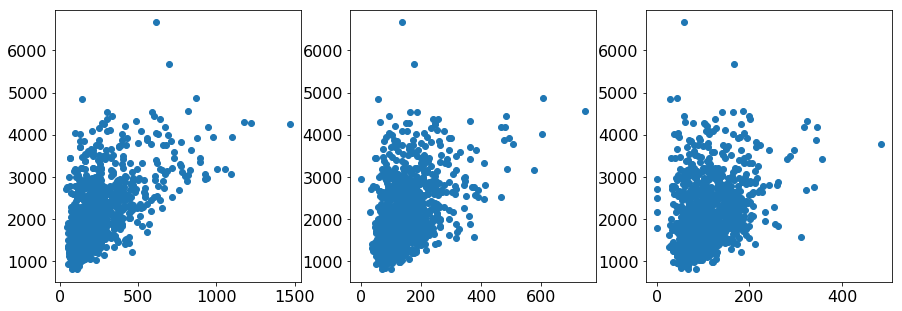

In [122]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(df['jet_pt1'],df['m4top'])
plt.subplot(132)
plt.scatter(df['jet_pt2'],df['m4top'])
plt.subplot(133)
plt.scatter(df['jet_pt3'],df['m4top'])

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(12,12), alpha=0.7, diagonal='hist')
plt.tight_layout()
plt.draw()

In [96]:
# Features and target
dataX = df.drop('m4top',axis=1)
dataY = df['m4top']

# Preparing cross validation samples
trainX, testX, trainY, testY = train_test_split(dataX, dataY, random_state=42, train_size=0.5)

In [97]:
rf_regre = RandomForestRegressor(n_estimators=500,n_jobs=-1).fit(trainX, trainY)

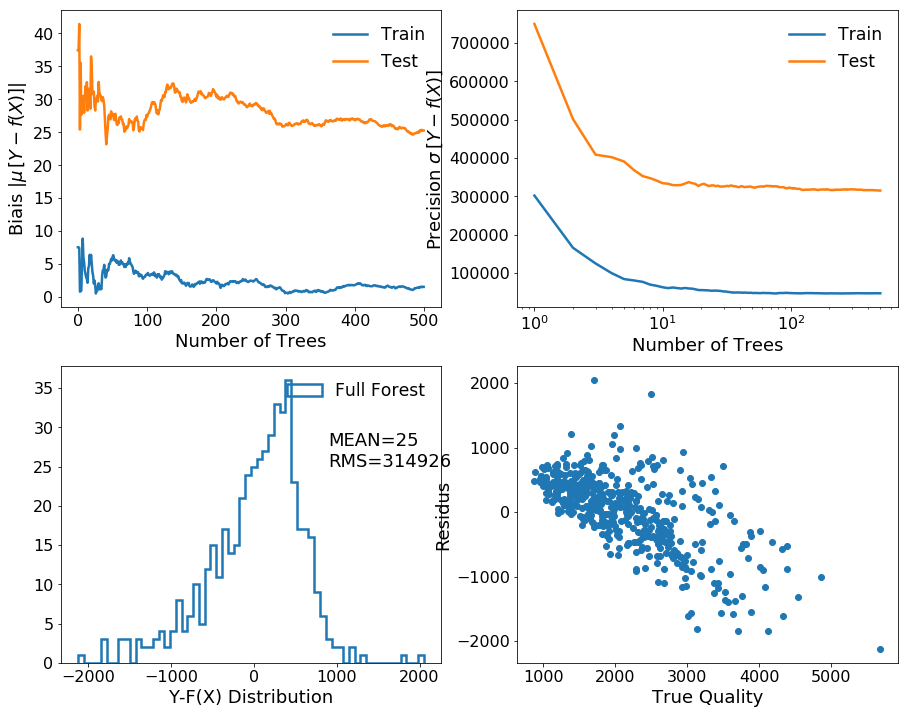

In [103]:
plt.figure(figsize=(15,12))

# 1. Check how the algorithm behaves with the number of trees
for sX, sY, label in [(trainX, trainY, 'Train'), (testX, testY, 'Test')]:
    predictions = np.zeros(len(sX))
    curve_rms   = []
    curve_mean  = []
    
    predictions = np.array( [tree.predict(sX) for tree in rf_regre.estimators_] )
    for i in range(0,rf_regre.n_estimators):
        if (i==0):
            Ypred=predictions[0]
        else:
            prediction_i = predictions[0:i]
            Ypred = np.average(prediction_i,axis=0)
            
        curve_rms .append( np.var(Ypred-sY) )
        curve_mean.append( np.abs(np.average(Ypred-sY)) )

    plt.subplot(221)
    plt.plot(curve_mean,label=label)
    plt.xlabel('Number of Trees')
    plt.ylabel('Biais $|\mu\,[Y-f(X)]|$')
    plt.legend()
    
    plt.subplot(222)
    plt.plot(curve_rms,label=label)
    plt.ylabel('Precision $\sigma\,[Y-f(X)]$')
    plt.xlabel('Number of Trees')
    plt.semilogx()
    plt.legend()

# 2. Plot the distribution for the final prediction    
Ypred = rf_regre.predict(testX)
Ytrue = testY
plt.subplot(223)
plt.xlabel('Y-F(X) Distribution')
plt.hist( Ypred-Ytrue ,bins=60, histtype='step', linewidth=2.5, label='Full Forest')
plt.text(900, 25, 'MEAN={:2.0f}\nRMS={:2.0f}'.format( np.average(Ypred-Ytrue), np.var(Ypred-Ytrue) ), fontsize=18)
plt.legend()

plt.subplot(224)
plt.xlabel('True Quality')
plt.ylabel('Residus')
plt.plot( Ytrue, Ypred-Ytrue, 'o')

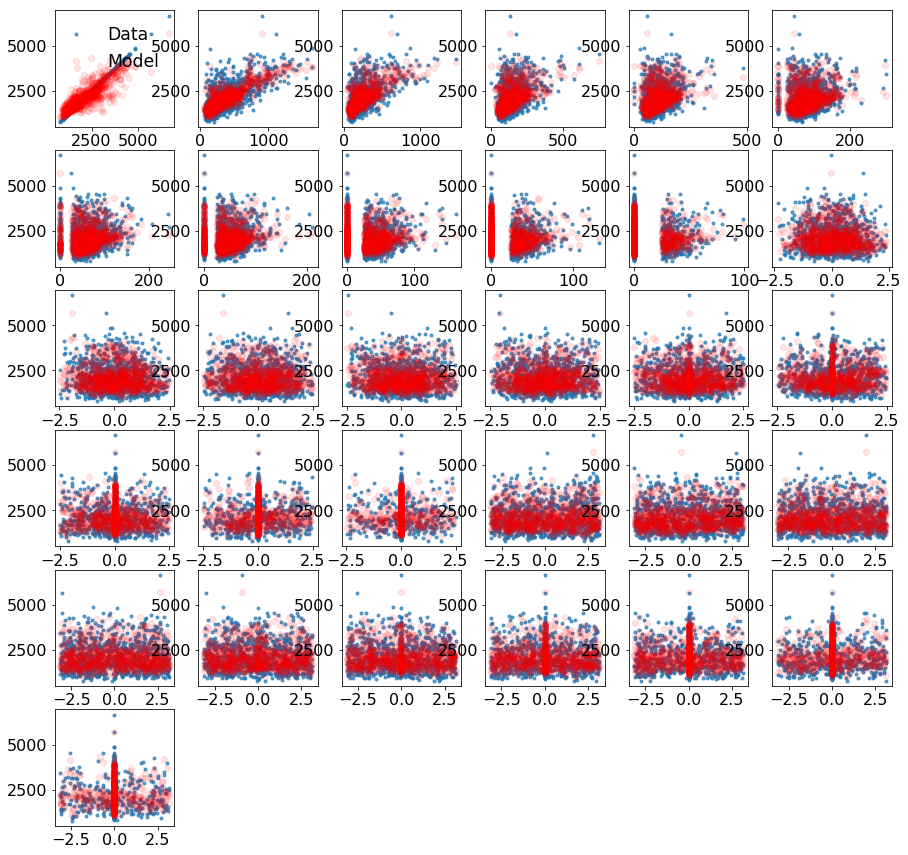

In [108]:
ymodel=rf_regre.predict(dataX)
y=df['m4top']

i=0
plt.figure(figsize=(15,15))
for varname in df.columns:
    i=i+1
    x=df[varname]
    plt.subplot(6,6,i)
    plt.plot(x,y,'.',alpha=0.7, label='Data')
    plt.plot(x,ymodel,'ro',alpha=0.1,label='Model')  
    if (i==1):
        plt.legend()